# possible bug: core execution does not pause when dispatcher FIFO is full

Each tProc v2 dispatcher output (waveform, data, or trigger output) has a FIFO, which by default is 512 words deep (`FIFO_DEPTH=9` https://github.com/awsch/qick-spin/blob/a76ab8dc0f4c3975af3ce6416b3a1b4d5bc77fbf/firmware/ip/qick_processor/src/axis_qick_processor.sv#L33). 
These FIFOs are filled as the program is executed, and empty as each pulse's scheduled time is reached.
A program that schedules a lot of pulses can fill up one of the FIFOs faster than the pulses get played.

The tProc is supposed to pause execution when any of the FIFOs is full. This was the behavior in tProc v1; in v2 there is a config flag that is supposed to control this behavior (but the default is to pause).
The manual describes this as "D_FIFO: Disable FIFO_FULL_PAUSE (default 0: used for Debug purpose)" - it says it's bit 10, but it's bit 11: https://github.com/awsch/qick-spin/blob/a76ab8dc0f4c3975af3ce6416b3a1b4d5bc77fbf/firmware/ip/qick_processor/src/qick_processor.sv#L215.

Anyway, it appears that this behavior doesn't actually work; the tProc does not pause-on-full, so fast sequences with more than 512 pulses on a single generator may lose the later pulses.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
from qick import *
import matplotlib.pyplot as plt
from qick.asm_v2 import AveragerProgramV2
from qick.asm_v2 import QickSweep1D

In [2]:
soc = QickSoc('/data/fw/2024-09-29_111_tprocv2r21_standard/qick_111.bit')
soccfg = soc

print(soccfg)

QICK running on ZCU111, software version 0.2.318

Firmware configuration (built Sun Sep 29 09:43:23 2024):

	Global clocks (MHz): tProc dispatcher timing 384.000, RF reference 204.800

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is DAC228_T0_CH1 or RF board output 1
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is DAC228_T0_CH2 or RF board output 2
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 3 is DAC228_T0_CH3 or RF board output 3
	4:	axi

In [3]:
hardware = {
        "drive_ch": 7,
        "ro_adc_ch": 0
    }

## example
This example plays 1000 short pulses and reads them out using the DDR4 buffer. The last two lines in the body slow down tProc execution to avoid FIFO overflow. If you comment them out, you will see that only half of the pulses get played.

Later on there is a test of setting the FIFO_FULL_PAUSE flag. This should disable pause-on-full, but it really seems that pause-on-full does not work regardless of the value of the flag.

In [4]:
class ManyPulseProg(AveragerProgramV2):
    def _initialize(self, cfg):  
        ro_ch = cfg["ro_adc_ch"]
        gen_ch = cfg["drive_ch"]

        self.declare_gen(ch=gen_ch, nqz=cfg['nqz_drive'])
        self.declare_readout(ch=ro_ch, length=cfg['readout_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['frequency_drive'], gen_ch=gen_ch)
        self.add_pulse(ch=gen_ch, name="pulse10", ro_ch=ro_ch, 
                   style="const", 
                   freq=cfg['frequency_drive'], 
                   length=cfg['len_drive'],
                   phase=0,
                   gain=1, 
                  )
        
        self.send_readoutconfig(ch=cfg['ro_adc_ch'], name="myro", t=0)
        self.delay(1.0) # create some execution slack for the trigger
        self.trigger(ddr4=True, t=0)
        
    def _body(self, cfg):
        for p in range(cfg['n_drive']):
            t = cfg['initial_drive'] + p*(cfg['len_drive']+cfg['gap_drive'])
            self.pulse(ch=cfg['drive_ch'], name = 'pulse10', t=t, tag="drivepulse%d"%(p))
            
            # if tProc execution gets too far ahead of the timeline, the pulse dispatcher will fill up
            # so: periodically insert a wait, to limit the execution slack to ~initial_drive
            # this is a dumb hack and you should not blindly reuse this (or use this ever, probably)
            # it's just a way to prove that we are seeing dispatcher overflow
            if cfg['wait_hack'] and p%100==0:
                self.wait(p*(cfg['len_drive']+cfg['gap_drive']))

In [5]:
n = 1000
initial_start = 50
gap_between_pulses = 0.1
pulse_len = 0.1

drive = {
    "frequency_drive": 500,
    "nqz_drive":1,
    'initial_drive':initial_start,
    'len_drive':pulse_len,
    'gap_drive':gap_between_pulses,
    'n_drive':n,
}
expt_config = {
    "wait_hack": False,
    "readout_length":5, # this is not actually used, we don't use the regular buffer
}
config = {**hardware, **drive, **expt_config}

In [6]:
soc.tproc.tproc_cfg = 0 # this is the default - just making sure
n_transfers = 2000
soc.arm_ddr4(ch=config['ro_adc_ch'], nt=n_transfers)
prog = ManyPulseProg(soccfg, reps=1, final_delay=10, cfg=config)

prog.run_rounds(soc, rounds=1)

iq_ddr4 = soc.get_ddr4(n_transfers)
t = prog.get_time_axis_ddr4(config['ro_adc_ch'], iq_ddr4)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# print(prog)

(45.0, 260.0)

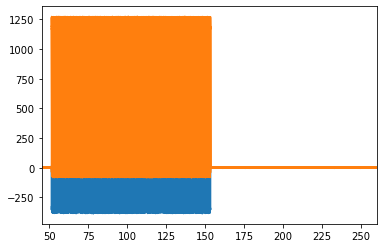

In [8]:
fig = plt.figure()
plt.plot(t, iq_ddr4[:,0])
plt.plot(t, iq_ddr4[:,1])
plt.xlim([initial_start-5,initial_start + n*(pulse_len+gap_between_pulses)+10])
# if all the pulses play, they should mostly fill the plot range

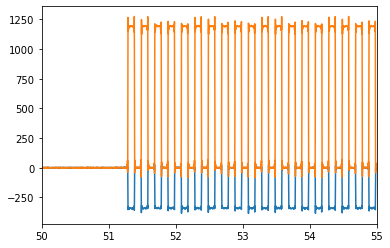

In [9]:
# zooming in on the first few pulses, to check spacing
fig.axes[0].set_xlim([50,55])
fig

In [10]:
# print as-compiled pulse times
for i in range(10):
    print(prog.get_time_param('drivepulse%d'%(i), 't'))

50.0
50.20052083333333
50.401041666666664
50.59895833333333
50.799479166666664
51.0
51.20052083333333
51.401041666666664
51.59895833333333
51.799479166666664


  0%|          | 0/1 [00:00<?, ?it/s]

(45.0, 260.0)

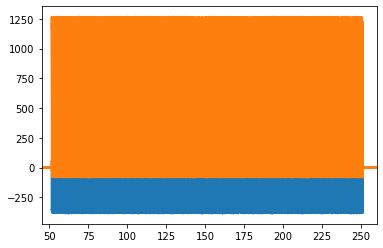

In [11]:
config['wait_hack'] = True

n_transfers = 2000
soc.arm_ddr4(ch=config['ro_adc_ch'], nt=n_transfers)
prog = ManyPulseProg(soccfg, reps=1, final_delay=10, cfg=config)
iq_list = prog.run_rounds(soc, rounds=1)
iq_ddr4 = soc.get_ddr4(n_transfers)
t = prog.get_time_axis_ddr4(config['ro_adc_ch'], iq_ddr4)

fig = plt.figure()
plt.plot(t, iq_ddr4[:,0])
plt.plot(t, iq_ddr4[:,1])
plt.xlim([initial_start-5,initial_start + n*(pulse_len+gap_between_pulses)+10])

setting tproc_cfg to 2048


  0%|          | 0/1 [00:00<?, ?it/s]

after run, tproc_cfg is 2048


(45.0, 260.0)

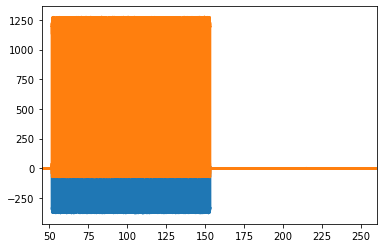

In [12]:
config['wait_hack'] = False

soc.tproc.tproc_cfg = 1 << 11 # this should disable pause-on-full
print("setting tproc_cfg to", soc.tproc.tproc_cfg)

n_transfers = 2000
soc.arm_ddr4(ch=config['ro_adc_ch'], nt=n_transfers)
prog = ManyPulseProg(soccfg, reps=1, final_delay=10, cfg=config)
iq_list = prog.run_rounds(soc, rounds=1)
iq_ddr4 = soc.get_ddr4(n_transfers)
t = prog.get_time_axis_ddr4(config['ro_adc_ch'], iq_ddr4)

# print to confirm that tproc_cfg didn't get changed by the library
print("after run, tproc_cfg is", soc.tproc.tproc_cfg)

fig = plt.figure()
plt.plot(t, iq_ddr4[:,0])
plt.plot(t, iq_ddr4[:,1])
plt.xlim([initial_start-5,initial_start + n*(pulse_len+gap_between_pulses)+10])